In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Model baseline

## Descarga del dataset

In [2]:
!wget https://storage.googleapis.com/diabetic-detection/data_downscaled.zip

--2020-11-09 11:41:48--  https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c04::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990385145 (945M) [application/zip]
Saving to: ‘data_downscaled.zip’

data_downscaled.zip 100%[===================>] 944.50M  26.9MB/s    in 39s     

2020-11-09 11:42:30 (24.0 MB/s) - ‘data_downscaled.zip’ saved [990385145/990385145]



In [3]:
!unzip -o -q data_downscaled
!mv .tmp dataset
!mv dataset/raw_dataset_extracted_downscaled data
!rm -rf dataset

In [4]:
!ls -l data

total 4296
drwxr-xr-x 2 root root    4096 Nov  6 05:56 sample
-rw-r--r-- 1 root root  709972 Nov  6 05:56 sampleSubmission.csv
drwxr-xr-x 2 root root 1974272 Nov  6 04:51 test
drwxr-xr-x 2 root root 1241088 Nov  6 05:56 train
-rw-r--r-- 1 root root  465317 Nov  6 05:56 trainLabels.csv


## Carga del dataset

In [5]:
import pandas as pd
import numpy as np
import os, sys, shutil

Creo el dataframe en orden lexicografico respecto los nombres de los archivos.

In [6]:
labels = pd.read_csv('data/trainLabels.csv') \
  .sort_values(by = 'image')

In [7]:
labels.head(2)

,image,level
7982,10003_left,0
7983,10003_right,0


In [8]:
labels.level.value_counts() / labels.level.shape[0], labels.level.value_counts()

(0    0.734783
 2    0.150658
 1    0.069550
 3    0.024853
 4    0.020156
 Name: level, dtype: float64, 0    25810
 2     5292
 1     2443
 3      873
 4      708
 Name: level, dtype: int64)

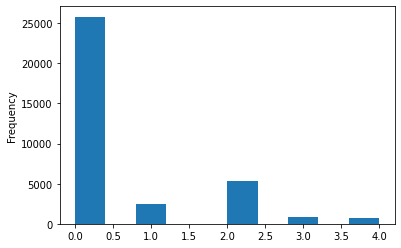

In [9]:
labels.level.plot(kind = 'hist')

## Resampling

Trabajo con maximo 1000 imagenes de cada clase para que esten mas balanceadas.

In [10]:
resampled = labels.groupby('level', as_index = False,group_keys=False) \
  .apply(lambda column: column.sample(min(len(column), 1000)))

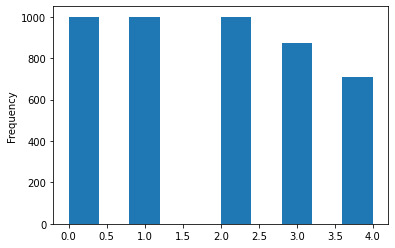

In [11]:
resampled.level.plot(kind = 'hist')

In [12]:
resampled = resampled.sort_values(by = 'image')

In [13]:
resampled.level.value_counts() / resampled.level.shape[0]

2    0.218293
1    0.218293
0    0.218293
3    0.190570
4    0.154551
Name: level, dtype: float64

In [14]:
resampled.shape[0]

4581

Creo una nueva carpeta de train mejor balanceada

In [15]:
orig_dir = 'data/train'
dest_dir = 'data/train_balanced'

if not os.path.exists(dest_dir):
  os.mkdir(dest_dir)

for _, item in resampled.image.items():
  ext = '.jpeg'
  orig_file = os.path.join(orig_dir, item + ext)
  dest_file = os.path.join(dest_dir, item + ext)
  shutil.copy(orig_file, dest_file)

Separo dos partes para test y validacion

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(resampled, train_size = 0.8, stratify = resampled.level)

In [17]:
train.shape[0], test.shape[0]

(3664, 917)

In [18]:
label_names = {
  0: 'No DR',
  1: 'Mild',
  2: 'Moderate',
  3: 'Severe',
  4: 'Proliferative DR'
}

In [19]:
def create_directory_flow(df, subset_name):
  for _, row in df.iterrows():
    item = row.image
    level = row['level']
    label_name = label_names[level]
    basedir = 'data/train_balanced'
    ext = '.jpeg'
    orig_file = os.path.join(basedir, item + ext)
    os.makedirs(os.path.join(basedir, subset_name, label_name), exist_ok=True)
    dest_file = os.path.join(basedir, subset_name, label_name, item + ext)
    shutil.copy(orig_file, dest_file)

In [20]:
create_directory_flow(train, 'train')
create_directory_flow(test, 'validation')

In [21]:
! rm -rf data/train_balanced/*.jpeg
! mv data/train_balanced data/balanced

Aprovecho para zipear y descargar este proceso, asi lo puedo utilizar en notebooks mas adelante.

In [22]:
train.to_csv('data/balanced/train_labels.csv')
test.to_csv('data/balanced/validation_labels.csv')

In [23]:
! cd data && zip -q -r 'flow_balanced_data.zip' 'balanced'

## Modelo baseline sin data augmentation

Para comenzar solamente aplicamos el reescalado, usando los canales de colores originales del dataset.

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_path = os.path.join('data', 'balanced', 'train')
validation_path = os.path.join('data', 'balanced', 'validation')

# Reescalamos todas las imágenes en un factor de 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# La función flow_from_directory() toma el path a un directorio
# y genera batches de data a la que aplica las transformaciones definidas
train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_path,
        # Reescalamos las imágenes a tamaño 150x150
        target_size=(224, 224),
        batch_size=32,
        # Usamos etiquetas binarias, ya que usamos binary_crossentropy
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 3664 images belonging to 5 classes.
Found 917 images belonging to 5 classes.


In [25]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [26]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    mode="auto",
    restore_best_weights=False,
)

In [28]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks = [early_stopping]
  )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
115/115 [==============================] - 18s 157ms/step - loss: 0.4991 - accuracy: 0.2203 - val_loss: 0.4969 - val_accuracy: 0.2345
Epoch 2/30
115/115 [==============================] - 17s 151ms/step - loss: 0.4957 - accuracy: 0.2462 - val_loss: 0.4936 - val_accuracy: 0.2443
Epoch 3/30
115/115 [==============================] - 17s 149ms/step - loss: 0.4930 - accuracy: 0.2639 - val_loss: 0.4914 - val_accuracy: 0.2639
Epoch 4/30
115/115 [==============================] - 17s 149ms/step - loss: 0.4895 - accuracy: 0.2778 - val_loss: 0.4875 - val_accuracy: 0.2770
Epoch 5/30
115/115 [==============================] - 17s 149ms/step - loss: 0.4858 - accuracy: 0.2950 - val_loss: 0.4846 - val_accuracy: 0.2912
Epoch 6/30
115/115 [==============================] - 17s 148ms/step - loss: 0.4814 - accuracy: 0.3169 - val_loss: 0.4884 - val_accuracy: 0.2737
Epoch 7/30
115/115 [==============================] - 

In [29]:
import matplotlib.pyplot as plt

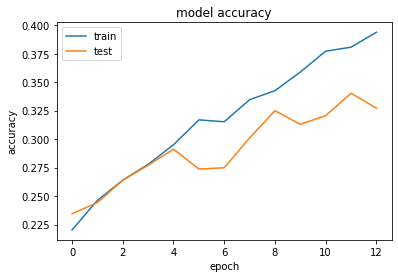

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

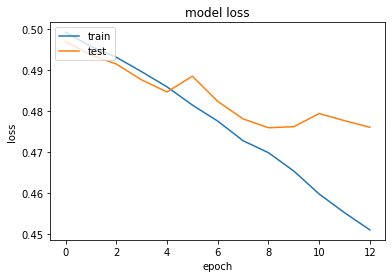

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model_save_name = 'Vainilla_3xConv.h5'
modelpath = f'/content/gdrive/My Drive/Deteccion de Diabetes/{model_save_name}'
model.save(modelpath)